<a href="https://colab.research.google.com/github/ReAlex1902/Tweets_Classification/blob/main/bert_with_catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
!pip install transformers

     |████████████████████████████████| 2.5MB 7.7MB/s 
     |████████████████████████████████| 3.3MB 21.8MB/s 
     |████████████████████████████████| 901kB 40.3MB/s 


In [1]:
## upload your kaggle.json

from google.colab import files
files.upload()

{}

In [ ]:
#before importing the dataset we want to use this code
# The Kaggle API client expects this file to be in ~/.kaggle,
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 66.0MB/s]
  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 137MB/s]
  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 22.9MB/s]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
PATH = '/content/train.csv'
df = pd.read_csv(PATH)
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
df.shape, df[df['target'] == 1].shape, df[df['target'] == 0].shape

((7613, 5), (3271, 5), (4342, 5))

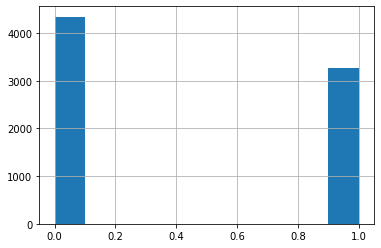

In [ ]:
df['target'].hist();

In [ ]:
from sklearn.utils import resample

df_minority = df[df['target'] == 1].copy()
df_minority_upsampled = resample(df_minority, replace = True, 
                                 n_samples = df['target'].value_counts()[0], 
                                 random_state = 11)
df_minority_upsampled.shape

(4342, 5)

In [ ]:
df = pd.concat([df[df['target'] == 0].copy(), df_minority_upsampled]).reset_index()
df.sample(5)

,index,id,keyword,location,text,target
293,498,721,attacked,Peshawar,IK Only Troll His Pol Rivals Never Literally A...,0
5894,5461,7789,police,Houston,CNN: Tennessee movie theater shooting suspect ...,1
5001,2013,2889,damage,Charlotte NC,REPORTED: HIT &amp; RUN-IN ROADWAY-PROPERTY DA...,1
1286,2062,2956,dead,NaN,i miss my longer hair..but it was so dead anyw...,0
52,104,151,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/yN...,0


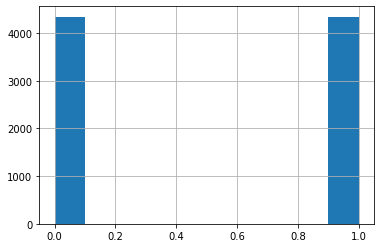

In [ ]:
df['target'].hist();

# Tokenization

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-cased', do_lower_case = True)

In [ ]:
sentence = df.loc[0, 'text']

print(sentence)
print(tokenizer.tokenize(sentence))
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentence)))

What's up man?
['what', "'", 's', 'up', 'man', '?']
[1184, 112, 188, 1146, 1299, 136]


In [ ]:
print(tokenizer.encode(sentence))

[101, 1184, 112, 188, 1146, 1299, 136, 102]


In [ ]:
print(tokenizer.encode_plus(sentence))

{'input_ids': [101, 1184, 112, 188, 1146, 1299, 136, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation, digits

nltk.download('stopwords')

def remove_punctuation(s):
    list_punctuation = list(punctuation)
    for i in list_punctuation:
        s = s.replace(i,'')
    return s.lower()

def clean_sentence(sentence, ):
    sentence = sentence.lower()
    sentence = re.sub(r'(\W)\1{2,}', r'\1', sentence) 
    sentence = re.sub(r'(\w)\1{2,}', r'\1\1', sentence)
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', '', sentence) # remove URL adresses
    # sentence = re.sub(r"\@(\w+)", '', sentence) # remove usernames
    # sentence = re.sub(r"\#(\w+)", '', sentence) # remove hashtags
    # sentence = re.sub(r"\$(\w+)", '', sentence) # remove cashtags
    sentence = sentence.replace("-",' ')
    tokens = sentence.split()
    # tokens = [remove_punctuation(w) for w in tokens] # remove punctuations
    stop_words = set(stopwords.words('english')) # remove stopwords
    tokens = [w for w in tokens if not w in stop_words]
    # remove_digits = str.maketrans('', '', digits)
    # tokens = [w.translate(remove_digits) for w in tokens]
    tokens = [w.strip() for w in tokens]
    tokens = [w for w in tokens if w!=""]
    tokens = ' '.join(tokens)
    tokens = tokens.replace("â", "")
    tokens = tokens.replace("@", "")
    tokens = tokens.replace("#", "")
    tokens = tokens.replace("$", "")
    return tokens

# clean_sentence(df.loc[4673, 'text'])

df['text'] = df['text'].apply(clean_sentence)
# df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df.sample(10)

,index,id,keyword,location,text,target
3633,6215,8866,smoke,WORLDWI$E,smoke much lmao scared text number bck makes s...,0
1089,1754,2523,collision,"Irving , Texas",anti collision rear technology cool via teches...,0
3117,5386,7686,panic,Milwaukee WI,someone asked monkey fist 2 feet long panic sn...,0
868,1342,1940,burning%20buildings,NaN,hero's fight wars save ppl burning buildings e...,0
3625,6206,8856,smoke,NaN,2014 smoke crqck becyme mayor. includes foursq...,0
6002,1661,2398,collapsed,"From NY. In Scranton, PA",apparently part building collapsed. hope every...,1
1262,2032,2916,danger,"Brooklyn, NY",take away: preservation parks r imposition &am...,0
4703,7421,10615,wounded,Yogya Berhati Nyaman,wocowae police officer wounded suspect dead ex...,1
2274,3843,5468,flames,"Manhattan, NY",'if can't summon flames directly hell store bo...,0
8343,2791,4017,disaster,Nigeria,cw500: dealing disaster,1


In [ ]:
class Config:
    batch_size = 32
    max_len = 0

In [ ]:
Config.max_len = 0

for sent in df.loc[:, 'text']:
    sent = tokenizer.encode(sent, add_special_tokens = True)
    Config.max_len = max(Config.max_len, len(sent))

Config.max_len

71

In [ ]:
input_ids = torch.tensor([])
attention_masks = torch.tensor([])

for sent in df.loc[:, 'text']:
    encoded_sent = tokenizer.encode_plus(sent, add_special_tokens = True,
                                         max_length = Config.max_len, padding = 'max_length',
                                         return_tensors = 'pt')
    input_ids = torch.cat([input_ids, encoded_sent['input_ids']])
    attention_masks = torch.cat([attention_masks, encoded_sent['attention_mask']])

In [ ]:
input_ids

tensor([[  101.,  1184.,   112.,  ...,     0.,     0.,     0.],
        [  101.,  1567., 11669.,  ...,     0.,     0.,     0.],
        [  101.,  2247.,  9020.,  ...,     0.,     0.,     0.],
        ...,
        [  101.,  9605.,  4680.,  ...,     0.,     0.,     0.],
        [  101.,  2824.,  3871.,  ...,     0.,     0.,     0.],
        [  101., 20454.,  2737.,  ...,     0.,     0.,     0.]])

In [ ]:
attention_masks

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])

In [ ]:
labels = torch.tensor(df['target'])
labels

tensor([0, 0, 0,  ..., 1, 1, 1])

In [ ]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)
val_size = int(0.1 * len(dataset))
train_size = len(dataset) - val_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [ ]:
len(train_dataset), len(val_dataset)

(7816, 868)

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_loader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = Config.batch_size)
val_loader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = Config.batch_size)

In [ ]:
next(iter(val_loader))

[tensor([[  101.,   112.,  1561.,  ...,     0.,     0.,     0.],
         [  101., 20013.,  2633.,  ...,     0.,     0.,     0.],
         [  101.,   196.,   131.,  ...,     0.,     0.,     0.],
         ...,
         [  101.,   176.,  7836.,  ...,     0.,     0.,     0.],
         [  101.,  9468.,  1197.,  ...,     0.,     0.,     0.],
         [  101.,   187.,  1204.,  ...,     0.,     0.,     0.]]),
 tensor([[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]]),
 tensor([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
         0, 0, 1, 0, 1, 1, 1, 1])]

# BERT

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

bert_model = BertForSequenceClassification.from_pretrained(
    'bert-base-cased',
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False
)

bert_model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def train_model(model, train_loader, val_loader, optimizer, num_epochs, scheduler = None):
    train_loss_history = []
    train_f1_history = []
    train_accuracy_history = []
    val_accuracy_history = []
    val_f1_history = []

    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        train_loss_accum = 0
        correct_samples = 0
        total_samples = 0

        tp, tn, fp, fn = 0, 0, 0, 0

        for index, (sentence, attention_mask, label) in enumerate(train_loader):
            model.zero_grad()

            sentence = sentence.to(device).long()
            attention_mask = attention_mask.to(device).long()
            label = label.to(device).long()

            output = model(sentence, token_type_ids = None, attention_mask = attention_mask, labels = label)
            loss_value, logits = output[0], output[1]
            train_loss_accum += loss_value.item()

            loss_value.backward()
            optimizer.step()
            if scheduler:
                scheduler.step()

            _, indices = torch.max(logits, 1)
            correct_samples += torch.sum(indices == label)
            tp += len(indices[(indices == label) & (indices == 1)])
            tn += len(indices[(indices == label) & (indices == 0)])
            fp += len(indices[(indices != label) & (indices == 1)])
            fn += len(indices[(indices != label) & (indices == 0)])
            total_samples += label.shape[0]
            
        avg_loss = train_loss_accum / index
        train_accuracy = float(correct_samples) / total_samples
        train_precision = tp / (tp + fp)
        train_recall = tp / (tp + fn)
        f1_train = (2*train_precision*train_recall) / (train_precision + train_recall)
        
        val_accuracy, f1_val = eval_model(model, val_loader)

        train_loss_history.append(avg_loss)
        train_accuracy_history.append(train_accuracy)
        train_f1_history.append(f1_train)
        val_accuracy_history.append(val_accuracy)
        val_f1_history.append(f1_val)

        print(f"EPOCH: {epoch}, Train_loss: {avg_loss}, Train_Acc: {train_accuracy}, Train_F1: {f1_train}, Val_Acc: {val_accuracy}, Val_F1: {f1_val}")
        if avg_loss < 0.05:
            return train_loss_history, train_accuracy_history, train_f1_history, val_accuracy_history, val_f1_history

    return train_loss_history, train_accuracy_history, train_f1_history, val_accuracy_history, val_f1_history

def eval_model(model, loader):

    model.eval() # Evaluation mode
    tp, tn, fp, fn = 0, 0, 0, 0
    correct_samples = 0
    total_samples = 0

    for sentence, attention_mask, label in loader:
        sentence = sentence.to(device).long()
        attention_mask = attention_mask.to(device).long()
        label = label.to(device).long()

        with torch.no_grad():
            preds = model(sentence, token_type_ids = None, attention_mask = attention_mask)
        
        _, indices = torch.max(preds[0], 1)
        correct_samples += torch.sum(indices == label)
        tp += len(indices[(indices == label) & (indices == 1)])
        tn += len(indices[(indices == label) & (indices == 0)])
        fp += len(indices[(indices != label) & (indices == 1)])
        fn += len(indices[(indices != label) & (indices == 0)])
        total_samples += label.shape[0]

    val_accuracy = float(correct_samples) / total_samples
    val_precision = tp / (tp + fp)
    val_recall = tp / (tp + fn)
    f1_val = (2*val_precision*val_recall) / (val_precision + val_recall)

    return val_accuracy, f1_val

In [ ]:
from transformers import get_linear_schedule_with_warmup

EPOCHS = 50

optimizer = AdamW(bert_model.parameters(), lr = 1e-5, eps = 1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = EPOCHS*len(train_dataset))

train_loss_history, train_accuracy_history, train_f1_history, val_acc_history, val_f1_history = \
                    train_model(bert_model, train_loader, val_loader, optimizer, EPOCHS, scheduler)

EPOCH: 0, Train_loss: 0.4802609926364461, Train_Acc: 0.7645854657113613, Train_F1: 0.7584033613445379, Val_Acc: 0.8329493087557603, Val_F1: 0.8346636259977195
EPOCH: 1, Train_loss: 0.3385046961732575, Train_Acc: 0.865532241555783, Train_F1: 0.8578769438810007, Val_Acc: 0.8467741935483871, Val_F1: 0.8465974625144175
EPOCH: 2, Train_loss: 0.23956825222331482, Train_Acc: 0.9078812691914022, Train_F1: 0.9044839479968162, Val_Acc: 0.8582949308755761, Val_F1: 0.8634850166481688
EPOCH: 3, Train_loss: 0.16290749048768374, Train_Acc: 0.9397389969293757, Train_F1: 0.9381808636303977, Val_Acc: 0.8652073732718893, Val_F1: 0.8724100327153763
EPOCH: 4, Train_loss: 0.11031401399752033, Train_Acc: 0.95496417604913, Train_F1: 0.9543331603528801, Val_Acc: 0.868663594470046, Val_F1: 0.876355748373102
EPOCH: 5, Train_loss: 0.07780815755230848, Train_Acc: 0.9704452405322416, Train_F1: 0.9701666020922123, Val_Acc: 0.8617511520737328, Val_F1: 0.8698481561822126
EPOCH: 6, Train_loss: 0.06883021080618358, Trai

# CatBoost

In [ ]:
!pip install catboost

     |████████████████████████████████| 69.2MB 42kB/s 


In [ ]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

cat_features = [0]
X_train, X_test, y_train, y_test = train_test_split(df['text'].values, df['target'].values, test_size = 0.1)

# cb = CatBoostClassifier(num_trees = 1000, task_type = 'GPU', eval_metric = 'F1', eta = 0.12, l2_leaf_reg = 5)
# cb = CatBoostClassifier(num_trees = 600, task_type = 'GPU', eval_metric = 'F1', eta = 0.12, l2_leaf_reg = 5, max_depth = 8)
cb = CatBoostClassifier(num_trees = 600, task_type = 'GPU', eval_metric = 'F1', eta = 0.12, l2_leaf_reg = 5, max_depth = 8)

In [ ]:
cb.fit(X_train, y_train, cat_features)

0:	learn: 0.8219298	total: 40.1ms	remaining: 24s
1:	learn: 0.8226064	total: 72.5ms	remaining: 21.7s
2:	learn: 0.8227260	total: 133ms	remaining: 26.5s
3:	learn: 0.8225877	total: 169ms	remaining: 25.2s
4:	learn: 0.8225360	total: 325ms	remaining: 38.6s
5:	learn: 0.8227054	total: 354ms	remaining: 35s
6:	learn: 0.8227904	total: 376ms	remaining: 31.9s
7:	learn: 0.8224843	total: 482ms	remaining: 35.7s
8:	learn: 0.8228954	total: 502ms	remaining: 32.9s
9:	learn: 0.8227756	total: 539ms	remaining: 31.8s
10:	learn: 0.8231184	total: 624ms	remaining: 33.4s
11:	learn: 0.8228954	total: 643ms	remaining: 31.5s
12:	learn: 0.8227571	total: 677ms	remaining: 30.6s
13:	learn: 0.8226371	total: 770ms	remaining: 32.2s
14:	learn: 0.8228772	total: 803ms	remaining: 31.3s
15:	learn: 0.8230489	total: 836ms	remaining: 30.5s
16:	learn: 0.8225500	total: 886ms	remaining: 30.4s
17:	learn: 0.8226702	total: 911ms	remaining: 29.4s
18:	learn: 0.8224982	total: 943ms	remaining: 28.8s
19:	learn: 0.8228755	total: 964ms	remaining

In [ ]:
from sklearn.metrics import f1_score
preds = [cb.predict([elem]) for elem in X_test]
f1_score(preds, y_test)

0.8644688644688645

# Test set

In [ ]:
TEST_PATH = '/content/test.csv'
df_test = pd.read_csv(TEST_PATH)
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
df_test['text'] = df_test['text'].apply(clean_sentence)
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,"heard earthquake different cities, stay safe e..."
2,3,NaN,NaN,"forest fire spot pond, geese fleeing across st..."
3,9,NaN,NaN,apocalypse lighting. spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills 28 china taiwan


In [ ]:
test_input_ids = torch.tensor([])
test_attention_masks = torch.tensor([])

for sent in df_test.loc[:, 'text']:
    encoded_sent = tokenizer.encode_plus(sent, add_special_tokens = True,
                                         max_length = Config.max_len, padding = 'max_length',
                                         return_tensors = 'pt')
    test_input_ids = torch.cat([test_input_ids, encoded_sent['input_ids']])
    test_attention_masks = torch.cat([test_attention_masks, encoded_sent['attention_mask']])

In [ ]:
test_input_ids

tensor([[  101.,  2171.,  6434.,  ...,     0.,     0.,     0.],
        [  101.,  1767.,  8386.,  ...,     0.,     0.,     0.],
        [  101.,  3304.,  1783.,  ...,     0.,     0.,     0.],
        ...,
        [  101.,  2448.,  1413.,  ...,     0.,     0.,     0.],
        [  101.,  1143.,  1403.,  ...,     0.,     0.,     0.],
        [  101.,  1331., 10008.,  ...,     0.,     0.,     0.]])

In [ ]:
test_attention_masks

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])

In [ ]:
test_dataset = TensorDataset(test_input_ids, test_attention_masks)
test_dataset[0]

(tensor([ 101., 2171., 6434., 1610., 5683.,  102.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.]),
 tensor([1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [ ]:
test_loader = DataLoader(test_dataset, sampler = SequentialSampler(test_dataset), batch_size = 1)

In [ ]:
next(iter(test_loader))

[tensor([[ 101., 2171., 6434., 1610., 5683.,  102.,    0.,    0.,    0.,    0.,
             0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
             0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
             0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
             0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
             0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
             0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
             0.]]),
 tensor([[1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])]

In [ ]:
def get_preds(bert_model, cb_model, loader, df_test):

    bert_model.eval() # Evaluation mode
    res = torch.tensor([])
    softmax = torch.nn.Softmax()

    for index, (sentence, attention_mask) in enumerate(loader):
        sentence = sentence.to(device).long()
        attention_mask = attention_mask.to(device).long()

        with torch.no_grad():
            bert_pred = bert_model(sentence, token_type_ids = None, attention_mask = attention_mask)
            bert_pred = softmax(bert_pred[0])
            cb_pred = cb_model.predict_proba([df_test.loc[index, 'text']])
            pred = (bert_pred + torch.tensor(cb_pred).to(device)) / 2
        
        _, indices = torch.max(pred, 1)
        res = torch.cat([res.to(device), indices.to(device)])

    return res

# get_preds(bert_model, test_loader)

In [ ]:
preds = get_preds(bert_model, cb, test_loader, df_test)
preds

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


tensor([1., 1., 1.,  ..., 1., 1., 1.], device='cuda:0')

In [ ]:
preds = pd.DataFrame({'id': df_test['id'], 'target': preds.cpu().int()})
preds.shape

(3263, 2)

In [ ]:
preds.to_csv('submission.csv', index = False)

# Save BERT

In [ ]:
# torch.save(bert_model.state_dict(), 'bert.pth')

In [ ]:
# modelB = BertForSequenceClassification.from_pretrained(
#     'bert-base-cased',
#     num_labels = 2,
#     output_attentions = False,
#     output_hidden_states = False
# ).to(device
#      )
# modelB.load_state_dict(torch.load(PATH)) #, strict = False)

# Save CatBoost

In [ ]:
# cb.save_model('CatBoostClassifier.cbm', format = 'cbm')

In [ ]:
# model = CatBoostClassifier()
# model.load_model('/content/CatBoostClassifier.cbm')